In [1]:
## DATALOADER

import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import mediapipe as mp
import random

# Define your class mappings
class_map = {'punch': 0, 'kick': 1, 'downtime': 2}

# Set up MediaPipe for pose detection
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Add Gaussian Noise
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size())*self.std+self.mean
        return tensor+noise
    
    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"
    



# Create transformations for data augmentation
augment_transformation = transforms.Compose([
    # transforms.ToPILImage(), #conver to PIL image (this has many built in functions for augmenting)
    # transforms.RandomHorizontalFlip(), #randomly flip image horizontally
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),  # Sharpening factor > 1 increases sharpness
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), #adjust brightness, contrast, saturation
    # transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(3/4, 4/3)),  # Random zoom and crop
    # transforms.Resize((224,224)),
    # transforms.ToTensor(),
    # AddGaussianNoise(mean=0.0, std=0.05),
    # transforms.Normalize((0.5), (0.5))


    
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),  # Simulate realistic variations
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Handle lighting differences
    transforms.Resize((224, 224)),  # Ensure consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

class PunchingBagDataset(Dataset):
    def __init__(self, data_dir, max_frames=16, frame_size=(64, 64), transform=None, indices=None):
        self.data_dir = data_dir
        self.max_frames = max_frames  # Max number of frames to extract per video
        self.frame_size = frame_size  # Size to resize each frame
        self.transform = transform
        self.data = []
        
        # Collect all video files and labels based on folders
        for class_name, class_idx in class_map.items():
            class_folder = os.path.join(data_dir, class_name)
            for file_name in os.listdir(class_folder):
                if file_name.endswith('.mov'):
                    self.data.append((os.path.join(class_folder, file_name), class_idx))


        if indices is not None:
            self.data = [self.data[i] for i in indices]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        video_path, label = self.data[idx]
        frames = []
        pose_keypoints = []

        # Load the video using OpenCV
        cap = cv2.VideoCapture(video_path)
        frame_count = 0

        while cap.isOpened() and frame_count < self.max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB and then to float32 with normalization
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            if self.transform:
                frame_tensor = self.transform(frame_rgb)
            else:
                frame_resized = cv2.resize(frame_rgb, self.frame_size)
                frame_tensor = torch.tensor(frame_resized).permute(2, 0, 1).float() / 255.0  # Convert to float32 and normalize
            frames.append(frame_tensor)

            # Perform pose estimation
            results = pose.process(frame_rgb)
            
            if results.pose_landmarks:
                # Extract keypoints (x, y coordinates)
                keypoints = torch.tensor([(lm.x, lm.y) for lm in results.pose_landmarks.landmark], dtype=torch.float32)
            else:
                keypoints = torch.zeros((33, 2), dtype=torch.float32)  # Placeholder if no pose detected
            pose_keypoints.append(keypoints)

            frame_count += 1

        cap.release()

        # Pad frames and keypoints if less than max_frames
        if len(frames) < self.max_frames:
            frames += [torch.zeros((3, *self.frame_size), dtype=torch.float32)] * (self.max_frames - len(frames))
            pose_keypoints += [torch.zeros((33, 2), dtype=torch.float32)] * (self.max_frames - len(pose_keypoints))

        # Stack frames and keypoints into tensors
        frames = torch.stack(frames)  # Shape: (max_frames, 3, H, W)
        pose_keypoints = torch.stack(pose_keypoints)  # Shape: (max_frames, 33, 2)

        return frames, pose_keypoints, label


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torchvision.models as models


class ResNetPunchingBag(nn.Module):
    def __init__(self, num_classes = 3):
        super(ResNetPunchingBag, self).__init__()
        # self.resnet = models.resnet18(weights=True)
        # self.resnet.fc = nn.Identity() #remove's classification layer so we can classify our data
        # self.temporal_pool = nn.AdaptiveAvgPool1d(1) #add some pooling
        # self.fc = nn.Linear(512, num_classes)
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')

        #Freeze layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        #remove classification layer
        self.resnet.fc = nn.Identity()
        


    # def forward(self, x):
    #     batch_size, seq_len, c, h, w = x.size()
    #     x = x.view(batch_size * seq_len, c, h, w) #Flatten temporal dimension
    #     features = self.resnet(x) #use resnet to extract features
    #     features = features.view(batch_size, seq_len, -1) #reshape to (B, T, F)
    #     features = features.permute(0, 2, 1)
    #     pooled_features = self.temporal_pool(features).squeeze(-1) # reshaped to (B,F)
    #     # out = self.fc(pooled_features) # get output classifications
    #     return pooled_features

    def forward(self, x):
        features = self.resnet(x)
        return features

c:\Users\bpohl\anaconda3\envs\aml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import ViTForImageClassification, ViTModel

vit = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels = 3
)

def forward_vit(vit_model, x):
    batch_size, seq_len, c, h, w = x.size()
    x = x.view(batch_size * seq_len, c, h, w)
    outputs = vit_model(pixel_values=x)
    # outputs = outputs.logits.view(batch_size, seq_len, -1) #reshape output to (B,T,C)
    # return outputs.mean(dim=1)
    return outputs.logits


class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224-in21k'):
        super(ViTFeatureExtractor, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name) #pretrained Vision Transformer

    def forward(self, x):
        outputs = self.vit(pixel_values = x)
        return outputs.last_hidden_state[:, 0, :] #return [batch_size, hidden size]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# class Fusion(nn.Module):
#     def __init__(self, resnet_model, vit, num_classes=3):
#         super(Fusion, self).__init__()
#         self.resnet_model = resnet_model
#         self.vit = vit

#         resnet_out_dim = 512#resnet_model.fc.in_features
#         vit_out_dim = vit.num_labels


#         self.fc = nn.Linear(resnet_out_dim + vit_out_dim, num_classes)

#     def forward(self, frames, keypoints):
#         resnet_out = self.resnet_model(frames) #resnet output
#         # print(f"ResNet output shape: {resnet_out.shape}")
#         vit_out = forward_vit(self.vit, frames) # ViT output
#         # print(f"ViT output shape: {vit_out.shape}")
#         combined = torch.cat((resnet_out, vit_out), dim=1) #concat features
#         # print(f"Combined shape: {combined.shape}")
#         out = self.fc(combined) #final classification
#         return out


# class FusionModel(nn.Module):
#     def __init__(self, resnet_model, vit_model, num_classes=3):
#         super(FusionModel, self).__init__()
#         self.resnet_model = resnet_model
#         self.vit_model = vit_model

#         # Define output dimensions
#         self.resnet_out_dim = 512  # ResNet18 output feature size
#         self.vit_out_dim = vit_model.config.hidden_size  # ViT hidden size
        
#         # Fully connected classification head
#         # self.fc = nn.Linear(self.resnet_out_dim + self.vit_out_dim, num_classes)
#         self.fc = nn.Linear(512 + 768, 3)  # Update based on resnet_out_dim + vit_out_dim


#     def forward(self, frames, keypoints=None):
#         batch_size, seq_len, c, h, w = frames.size()

#         # Flatten temporal dimension for ResNet
#         frames_flat = frames.view(batch_size * seq_len, c, h, w)  # Shape: [batch_size * seq_len, c, h, w]

#         # Extract features using ResNet
#         resnet_features = self.resnet_model(frames_flat)  # Shape: [batch_size * seq_len, 512]
#         resnet_features = resnet_features.view(batch_size, seq_len, -1)  # [batch_size, seq_len, 512]
#         resnet_features = resnet_features.mean(dim=1)  # Average temporal: [batch_size, 512]

#         # Extract features using ViT
#         vit_features = self.vit_model(pixel_values=frames_flat).logits  # [batch_size * seq_len, 768]
#         vit_features = vit_features.view(batch_size, seq_len, -1)  # [batch_size, seq_len, 768]
#         vit_features = vit_features.mean(dim=1)  # Average temporal: [batch_size, 768]

#         # Debugging output shapes
#         print(f"ResNet features shape: {resnet_features.shape}")  # Should be [batch_size, 512]
#         print(f"ViT features shape: {vit_features.shape}")        # Should be [batch_size, 768]

#         # Concatenate ResNet and ViT features
#         combined_features = torch.cat((resnet_features, vit_features), dim=1)  # [batch_size, 512 + 768]

#         # Pass through classification head
#         out = self.fc(combined_features)
#         return out





class FusionModel(nn.Module):
    def __init__(self, resnet_model, vit_model, num_classes=3):
        super(FusionModel, self).__init__()
        self.resnet_model = resnet_model
        self.vit_model = vit_model

        # Define output dimensions
        self.resnet_out_dim = 512  # ResNet18 output feature size
        self.vit_out_dim = 768  # ViT hidden size (updated for ViTModel)

        # Fully connected classification head
        self.fc = nn.Linear(self.resnet_out_dim + self.vit_out_dim, num_classes)

    def forward(self, frames, keypoints=None):
        batch_size, seq_len, c, h, w = frames.size()

        # Flatten temporal dimension for ResNet
        frames_flat = frames.view(batch_size * seq_len, c, h, w)  # Shape: [batch_size * seq_len, c, h, w]

        # Extract features using ResNet
        resnet_features = self.resnet_model(frames_flat)  # Shape: [batch_size * seq_len, 512]
        resnet_features = resnet_features.view(batch_size, seq_len, -1)  # [batch_size, seq_len, 512]
        resnet_features = resnet_features.mean(dim=1)  # Temporal pooling: [batch_size, 512]

        # Extract features using ViT
        vit_features = self.vit_model(frames_flat)  # Shape: [batch_size * seq_len, 768]
        vit_features = vit_features.view(batch_size, seq_len, -1)  # [batch_size, seq_len, 768]
        vit_features = vit_features.mean(dim=1)  # Temporal pooling: [batch_size, 768]

        # Debugging output shapes
        # print(f"ResNet features shape: {resnet_features.shape}")  # Should be [batch_size, 512]
        # print(f"ViT features shape: {vit_features.shape}")        # Should be [batch_size, 768]

        # Concatenate ResNet and ViT features
        combined_features = torch.cat((resnet_features, vit_features), dim=1)  # [batch_size, 512 + 768]

        # Pass through classification head
        out = self.fc(combined_features)
        return out



In [5]:
# ## CALL AND TRAIN MODEL


# import torch.optim as optim
# from sklearn.metrics import accuracy_score

# # Initialize model, loss, and optimizer
# model = VideoClassifier()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Training loop
# def train(model, train_loader, criterion, optimizer, device):
#     model.train()
#     total_loss = 0.0
#     for frames, keypoints, labels in train_loader:
#         frames, keypoints, labels = frames.to(device), keypoints.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(frames, keypoints)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(train_loader)

# # Testing loop
# def test(model, test_loader, device):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for frames, keypoints, labels in test_loader:
#             frames, keypoints, labels = frames.to(device), keypoints.to(device), labels.to(device)
#             outputs = model(frames, keypoints)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#     return accuracy_score(all_labels, all_preds)

# # Example of using DataLoader and training/testing loops
# data_directory = './dataset'
# dataset = PunchingBagDataset(data_directory)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=4)

# num_epochs = 10
# for epoch in range(num_epochs):
#     train_loss = train(model, train_loader, criterion, optimizer, device)
#     test_acc = test(model, test_loader, device)
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}")

In [6]:
# from torch.utils.data import DataLoader

# dataset = PunchingBagDataset(data_dir='./dataset', max_frames=16, frame_size=(224,224))
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# #Model and transformer
# resnet_model = ResNetPunchingBag(num_classes=3)
# vit = vit
# fusion = Fusion(resnet_model, vit)


# # Optimizer and Loss
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(fusion.parameters(), lr=1e-4)

# #training loop
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# fusion.to(device)

# for epoch in range(5):
#     fusion.train()
#     running_loss = 0
#     correct_predictions = 0
#     total_predictions = 0

#     for frames, keypoints, labels in dataloader:
#         frames, labels = frames.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = fusion(frames, keypoints)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         # Compute accuracy
#         _, predicted = torch.max(outputs, 1)  # Get predicted class
#         correct_predictions += (predicted == labels).sum().item()
#         total_predictions += labels.size(0)

#     epoch_loss = running_loss / len(dataloader)
#     epoch_accuracy = 100 * correct_predictions / total_predictions

#     print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

In [7]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Evaluate the model on the test or validation set
# fusion.eval()
# all_labels = []
# all_preds = []
# all_probs = []

# with torch.no_grad():
#     for frames, keypoints, labels in dataloader:  # Replace with test_dataloader if available
#         frames, labels = frames.to(device), labels.to(device)
#         outputs = fusion(frames, keypoints)  # Get model predictions
#         probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
#         _, preds = torch.max(outputs, 1)  # Get predicted class
        
#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(preds.cpu().numpy())
#         all_probs.extend(probs.cpu().numpy())

# # Convert to numpy arrays
# all_labels = np.array(all_labels)
# all_preds = np.array(all_preds)
# all_probs = np.array(all_probs)

# # Compute metrics
# precision = precision_score(all_labels, all_preds, average='weighted')
# recall = recall_score(all_labels, all_preds, average='weighted')
# f1 = f1_score(all_labels, all_preds, average='weighted')

# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

# # Classification report
# class_names = ['punch', 'kick', 'downtime']  # Update with your class names
# print("\nClassification Report:\n")
# print(classification_report(all_labels, all_preds, target_names=class_names))

# # Confusion matrix
# cm = confusion_matrix(all_labels, all_preds)

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()

# # AUC-ROC curves
# from sklearn.preprocessing import label_binarize

# # Binarize labels for multi-class AUC
# all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))

# plt.figure(figsize=(10, 8))
# for i in range(len(class_names)):
#     fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('AUC-ROC Curves')
# plt.legend(loc='lower right')
# plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Create the full dataset
full_dataset = PunchingBagDataset(data_dir='./dataset', max_frames=16, frame_size=(224, 224))

# Get indices for splitting
dataset_size = len(full_dataset)
indices = list(range(dataset_size))

# Split indices into training (70%), validation (15%), and test (15%)
train_indices, test_val_indices = train_test_split(indices, test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(test_val_indices, test_size=0.5, random_state=42)

# Create datasets for each split
train_dataset = PunchingBagDataset(data_dir='./dataset', max_frames=16, frame_size=(224, 224), indices=train_indices, transform=augment_transformation)
val_dataset = PunchingBagDataset(data_dir='./dataset', max_frames=16, frame_size=(224, 224), indices=val_indices)
test_dataset = PunchingBagDataset(data_dir='./dataset', max_frames=16, frame_size=(224, 224), indices=test_indices)


from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

#Model and transformer
# resnet_model = ResNetPunchingBag(num_classes=3)
# vit = vit
# fusion = Fusion(resnet_model, vit)

# resnet_feature_extractor = ResNetPunchingBag()
# vit_model = ViTForImageClassification.from_pretrained(
#     'google/vit-base-patch16-224-in21k', num_labels=3
# )

# # Initialize the fusion model
# fusion = FusionModel(resnet_model=resnet_feature_extractor, vit_model=vit_model, num_classes=3)

# Initialize ResNet and ViT feature extractors
resnet_model = ResNetPunchingBag()
vit_model = ViTFeatureExtractor(model_name='google/vit-base-patch16-224-in21k')

# Initialize the Fusion Model
fusion = FusionModel(resnet_model=resnet_model, vit_model=vit_model, num_classes=3)





# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fusion.parameters(), lr=1e-5)

#training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fusion.to(device)



for epoch in range(15):
    # Training Phase
    fusion.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for frames, keypoints, labels in train_loader:
        frames, labels = frames.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = fusion(frames, keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = 100 * train_correct / train_total

    # Validation Phase
    fusion.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, keypoints, labels in val_loader:
            frames, labels = frames.to(device), labels.to(device)
            outputs = fusion(frames, keypoints)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = 100 * val_correct / val_total

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")




c:\Users\bpohl\anaconda3\envs\aml\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Epoch 1, Train Loss: 1.0699, Train Accuracy: 42.68%
Validation Loss: 1.1730, Validation Accuracy: 35.29%
Epoch 2, Train Loss: 0.9648, Train Accuracy: 53.50%
Validation Loss: 1.1334, Validation Accuracy: 41.18%
Epoch 3, Train Loss: 0.8731, Train Accuracy: 68.79%
Validation Loss: 1.1207, Validation Accuracy: 41.18%
Epoch 4, Train Loss: 0.7995, Train Accuracy: 80.25%
Validation Loss: 1.0792, Validation Accuracy: 47.06%
Epoch 5, Train Loss: 0.7179, Train Accuracy: 85.35%
Validation Loss: 1.0547, Validation Accuracy: 47.06%
Epoch 6, Train Loss: 0.6425, Train Accuracy: 87.26%
Validation Loss: 1.0486, Validation Accuracy: 47.06%
Epoch 7, Train Loss: 0.5665, Train Accuracy: 91.08%
Validation Loss: 1.0088, Validation Accuracy: 47.06%
Epoch 8, Train Loss: 0.4988, Train Accuracy: 93.63%
Validation Loss: 0.9935, Validation Accuracy: 47.06%
Epoch 9, Train Loss: 0.4335, Train Accuracy: 93.63%
Validation Loss: 1.0206, Validation Accuracy: 47.06%
Epoch 10, Train Loss: 0.3896, Train Accuracy: 97.45%
Va

c:\Users\bpohl\anaconda3\envs\aml\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Test Accuracy: 55.88%


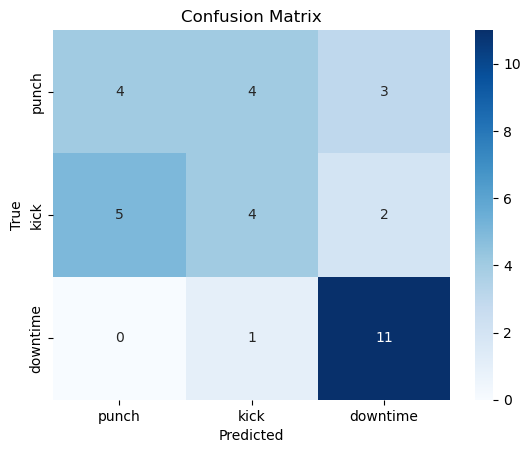

              precision    recall  f1-score   support

       punch       0.44      0.36      0.40        11
        kick       0.44      0.36      0.40        11
    downtime       0.69      0.92      0.79        12

    accuracy                           0.56        34
   macro avg       0.53      0.55      0.53        34
weighted avg       0.53      0.56      0.54        34



In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Test Phase
fusion.eval()
test_correct = 0
test_total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for frames, keypoints, labels in test_loader:
        frames, labels = frames.to(device), labels.to(device)
        outputs = fusion(frames, keypoints)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(class_map.values()))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_map.keys(), yticklabels=class_map.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_map.keys()))
